# Reception Quality and Gap Lenght Evaluation

This notebook contains code for evaluating satellite reception quality and the sensitivity to certain methodological choices, such as restricting included vessel classes and limiting vessel speed. It also includes analysis of AIS gap length.

Figures and analyses are to be included in the paper's Supplementary Information.

In [37]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import colors,colorbar, cm

import pyseas
import pyseas.maps
import pyseas.maps.rasters
import pyseas.styles
import pyseas.cm
import cmocean

# Direct notebook to see local modules for import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_production import utils

%load_ext autoreload
%autoreload 2
%load_ext google.cloud.bigquery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parameters
destination_dataset = 'proj_ais_gaps_catena'
output_version = 'v20210722'
start_date = pd.date_range('2017-01-01', '2017-01-01', freq='1D')[0]

# Reception quality tables
sat_reception_smoothed_tbl = 'sat_reception_smoothed_one_degree_{}'.format(output_version)
sat_reception_measured_tbl = 'sat_reception_measured_one_degree_{}'.format(output_version)

## Reception quality
### Measured reception

Query data.

In [17]:
"""
Query measured reception data
"""
sat_reception_measured_query = '''SELECT 
                                   lat_bin,
                                   lon_bin,
                                   cls as class,
                                   AVG(sat_pos_per_day) as positions_per_day
                                   FROM `{d}.{t}`
                                   WHERE _partitiontime BETWEEN "2017-01-01" 
                                   AND "2019-12-01"
                                   GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                            t = sat_reception_measured_tbl)
# Query data
sat_reception_measured = pd.read_gbq(sat_reception_measured_query, project_id='world-fishing-827', dialect='standard')

Plot measured reception.

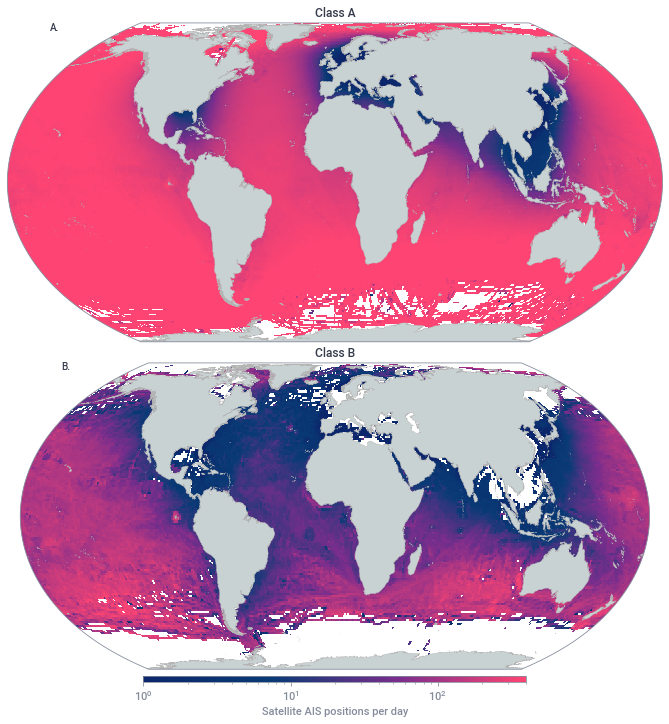

In [28]:
# Drop NAs
sat_reception_measured = sat_reception_measured.dropna(subset=['lat_bin','lon_bin'])

# Class A
class_a_reception = pyseas.maps.rasters.df2raster(sat_reception_measured[sat_reception_measured['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','positions_per_day',
                                                  xyscale=1, 
                                                  per_km2=False)

# Class B
class_b_reception = pyseas.maps.rasters.df2raster(sat_reception_measured[sat_reception_measured['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','positions_per_day',
                                                  xyscale=1, 
                                                  per_km2=False)

fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light):
    
    axes = []
    ims = []
    fig_min_value = 1
    fig_max_value = 400  
    
    # Class A
    grid = class_a_reception
    grid[grid<fig_min_value/fig_max_value]=np.nan
    norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = 'reception',
                                     norm = norm)
    
    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")
    
    # Class B
    grid = class_b_reception
    grid[grid<fig_min_value/fig_max_value]=np.nan
    norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)
    
    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap='reception',
                                     norm = norm)
    
    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")
    
    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )
    
    cbar.set_label("Satellite AIS positions per day")
    
plt.tight_layout(pad=0.5)
plt.savefig("../results/gap_figures_{}/figure_si_measured_reception.png".format(output_version),dpi=200, bbox_inches='tight') 

### Smooth reception

In [3]:
"""
Query smoothed reception data
"""
sat_reception_smooth_query = '''SELECT 
                                   lat_bin,
                                   lon_bin,
                                   class,
                                   AVG(positions_per_day) as positions_per_day
                                   FROM `{d}.{t}`
                                   WHERE _partitiontime BETWEEN "2017-01-01" 
                                   AND "2019-12-01"
                                   GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                            t = sat_reception_smoothed_tbl)
# Query data
sat_reception_smooth = pd.read_gbq(sat_reception_smooth_query, project_id='world-fishing-827', dialect='standard')

/opt/miniconda3/envs/rad/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


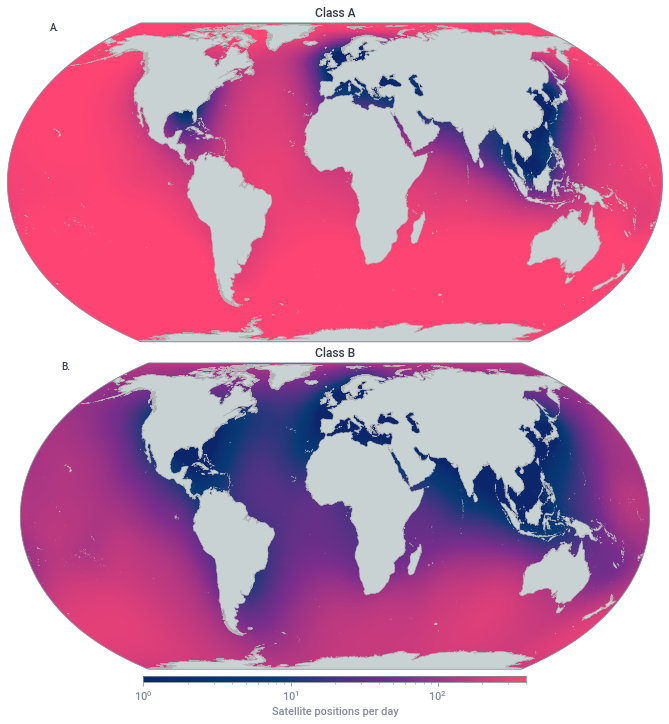

In [30]:
# Plot reception quality with same color scales
utils.plot_reception_quality(reception_start_date = start_date,
                             reception_df = sat_reception_smooth
                        )

# Save figure
plt.savefig("../results/gap_figures_{}/figure_si_smooth_reception.png".format(output_version),dpi=200, bbox_inches='tight') 

### Residuals

Remake residual plot with different color scales for class A and B. 

First, pull out the measured reception quality to compare against the smoothed reception quality.

In [38]:
%%bigquery sat_residuals
WITH

smooth AS (
  SELECT 
  lat_bin,
  lon_bin,
  class,
  AVG(positions_per_day) as positions_per_day
  FROM proj_ais_gaps_catena.sat_reception_smoothed_one_degree_v20210722
  WHERE _partitiontime BETWEEN "2017-01-01" AND "2019-12-01"
  GROUP BY 1,2,3
),

measured AS (
  SELECT 
  lat_bin,
  lon_bin,
  cls as class,
  AVG(sat_pos_per_day) as positions_per_day_measured,
  SUM(hours) as hours
  FROM proj_ais_gaps_catena.sat_reception_measured_one_degree_v20210722
  WHERE _partitiontime BETWEEN "2017-01-01" AND "2019-12-01"
  GROUP BY 1,2,3
)

SELECT
*,
positions_per_day_measured - positions_per_day as residual,
positions_per_day_measured_cap - positions_per_day_cap as residual_cap
FROM (
  SELECT 
  *,
  IF(positions_per_day_measured > 100, 100, positions_per_day_measured) as positions_per_day_measured_cap,
  IF(positions_per_day > 100, 100, positions_per_day) as positions_per_day_cap
  FROM measured
  LEFT JOIN smooth
  USING (lat_bin, lon_bin, class)
)
WHERE hours > 24

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 59556/59556 [00:01<00:00, 37731.47rows/s]


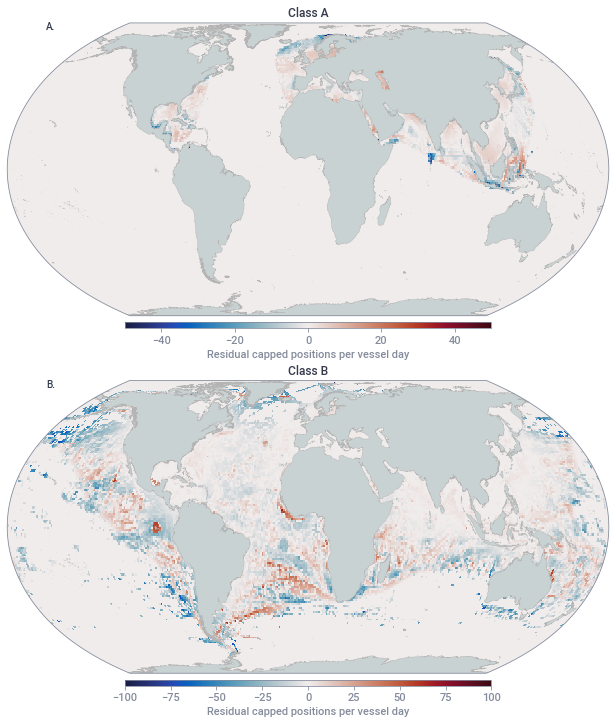

In [39]:
# Remove NA coordinate rows
sat_residuals = sat_residuals.dropna(subset=['lat_bin','lon_bin'])

# Pull out class A and B capped residuals
class_a_cap_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','residual_cap',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_cap_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','residual_cap',
                                                  xyscale=1, 
                                                  per_km2=False)

# Plot
fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light): 

    axes = []
    ims = []
    fig_a_min_value = -50
    fig_a_max_value = 50  

    # Class A
    grid = class_a_cap_residuals
    norm = colors.Normalize(vmin=fig_a_min_value, vmax=fig_a_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Residual capped positions per vessel day")
    
    # Class B
    fig_b_min_value = -100
    fig_b_max_value = 100
    
    grid = class_b_cap_residuals
    norm = colors.Normalize(vmin=fig_b_min_value, vmax=fig_b_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Residual capped positions per vessel day")

    plt.tight_layout(pad=0.5)
plt.savefig("../results/gap_figures_{}/figure_si_reception_residuals.png".format(output_version),dpi=200, bbox_inches='tight') 

### Residual histograms

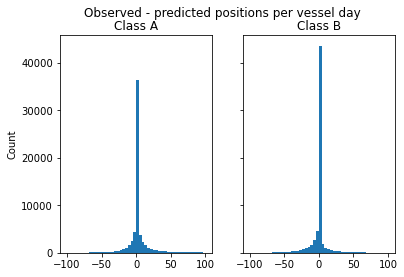

In [36]:
# Pull out class A and B capped residuals
class_a_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','residual',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','residual',
                                                  xyscale=1, 
                                                  per_km2=False)

# set axes range
ax_range = 100
bins = 50

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=False)
fig.suptitle('Observed - predicted positions per vessel day')

ax1.hist(class_a_residuals.flatten(), range=(-ax_range, ax_range), bins=bins)
ax1.title.set_text('Class A')
ax1.set(ylabel = 'Count')

ax2.hist(class_b_residuals.flatten(), range=(-ax_range, ax_range), bins=bins)
ax2.title.set_text('Class B')

# Save figure
plt.savefig('../results/gap_figures_{}/figure_si_residual_distribution.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])

## Gap length

Get the lenght of all AIS gaps, with suspected disabling events labeled.

In [41]:
%%bigquery gap_length
SELECT 
  ssvid,
  vessel_class,
  off_class,
  gap_hours,
  gap_distance_m / 1000 as gap_distance_km,
  IF (
   positions_X_hours_before_sat >= 19 
   AND (positions_per_day_off > 5 AND positions_per_day_on > 5), True,  False
  ) as likely_disabling
FROM `world-fishing-827.proj_ais_gaps_catena.ais_gap_events_features_v20210722` 
WHERE gap_hours >= 12
AND (off_distance_from_shore_m > 1852*50 AND on_distance_from_shore_m > 1852*50)
AND (DATE(gap_start) >= '2017-01-01' AND DATE(gap_end) <= '2019-12-31')

Downloading: 100%|██████████████████████████████████████████████████████████████████| 407421/407421 [00:01<00:00, 206834.21rows/s]


In [42]:
gap_length

,ssvid,vessel_class,off_class,gap_hours,gap_distance_km,likely_disabling
0,412440434,purse_seines,B,17.283333,18.813744,False
1,503667400,pots_and_traps,B,12.133333,4.877416,True
2,412440483,purse_seines,B,108.350000,11.542955,False
3,316021795,pots_and_traps,B,12.533333,3.460402,False
4,412365286,other_purse_seines,B,153.866667,89.072461,False
...,...,...,...,...,...,...
407416,431700454,drifting_longlines,B,22.700000,61.830526,False
407417,416002847,drifting_longlines,B,12.183333,32.419031,False
407418,416002231,drifting_longlines,B,13.416667,13.068638,False
407419,416003306,drifting_longlines,B,12.150000,20.778551,False


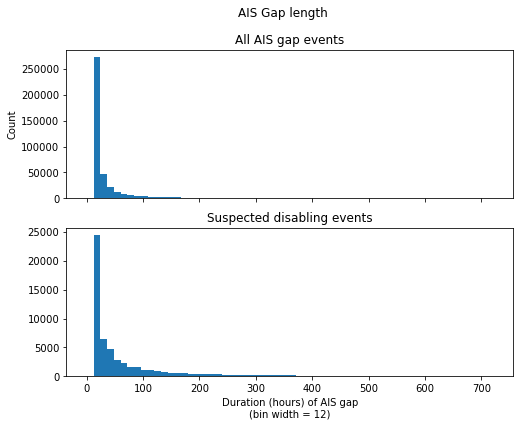

In [85]:
# set axes range
ax_range = 24*30
bins = 60

fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, sharex=True, figsize = (8,6))
fig.suptitle('AIS Gap length')

ax1.hist(gap_length['gap_hours'], 
         range=(0, ax_range),
         bins=bins)

ax1.title.set_text('All AIS gap events')
ax1.set(ylabel = 'Count')

ax2.hist(gap_length.loc[gap_length['likely_disabling'] == True, 'gap_hours'], 
         range=(0, ax_range),
         bins=bins)

ax2.title.set_text('Suspected disabling events')
ax2.set(xlabel = 'Duration (hours) of AIS gap\n(bin width = 12)')

plt.savefig('../results/gap_figures_{}/figure_si_gap_hours_hist.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])

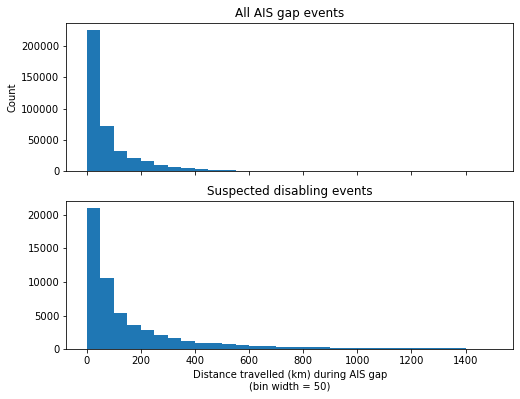

In [86]:
# set axes range
ax_range = 1500
bins = 30

fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, sharex=True, figsize=(8,6))

ax1.hist(gap_length['gap_distance_km'], 
         range=(0, ax_range),
         bins=bins)

ax1.title.set_text('All AIS gap events')
ax1.set(ylabel = 'Count')

ax2.hist(gap_length.loc[gap_length['likely_disabling'] == True, 'gap_distance_km'], 
         range=(0, ax_range),
         bins=bins)

ax2.title.set_text('Suspected disabling events')
ax2.set(xlabel = 'Distance travelled (km) during AIS gap\n(bin width = 50)')

plt.savefig('../results/gap_figures_{}/figure_si_gap_distance_hist.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])